# 1. Import and Install Dependencies

In [1]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
import pyttsx3 as audio

In [2]:
class Braimah:
    mp_holistic = mp.solutions.holistic # Holistic model
    mp_drawing = mp.solutions.drawing_utils # Drawing utilities
    no_sequences = 60 # number of videos per action
    frame_length = 30 # length of frames
    DATA_PATH: os.path = os.path.join('data_with_gloves')
    threshold = 0.9
    selected_actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','dot','space'])

    def mediapipe_detection(self,image, model):
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
        img.flags.writeable = False                  # Image is no longer writeable
        res = model.process(image)                 # Make prediction
        img.flags.writeable = True                   # Image is now writeable
        img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
        return img, res

    def draw_styled_landmarks(self, image, results, pose):
        if pose:
            self.mp_drawing.draw_landmarks(image, results.pose_landmarks, self.mp_holistic.POSE_CONNECTIONS,
                                self.mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=4),
                                Braimah.mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                                )
        else:
            pass
        # Draw left-hand connections
        self.mp_drawing.draw_landmarks(image, results.left_hand_landmarks, self.mp_holistic.HAND_CONNECTIONS,
                             self.mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             self.mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
        # Draw right-hand connections
        self.mp_drawing.draw_landmarks(image, results.right_hand_landmarks, self.mp_holistic.HAND_CONNECTIONS,
                             self.mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             self.mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    def show_image(self, image):
        cv2.imshow('Openfeed CV',image)

    def extract_datapoints(self, frame_results, pose):
        ps = np.array([[rs.x, rs.y, rs.z, rs.visibility] for rs in frame_results.pose_landmarks.landmark]).flatten() if frame_results.pose_landmarks else np.zeros(132)
        lh = np.array([[rs.x, rs.y, rs.z] for rs in frame_results.left_hand_landmarks.landmark]).flatten() if frame_results.left_hand_landmarks else np.zeros(21*3)
        rh = np.array([[rs.x, rs.y, rs.z] for rs in frame_results.right_hand_landmarks.landmark]).flatten() if frame_results.right_hand_landmarks else np.zeros(21*3)
        if pose:
            return np.concatenate([ps, lh, rh])
        else:
            return np.concatenate([lh,rh])

    def create_folders(self):
        for action in self.selected_actions:
            for sequence in range(self.no_sequences):
                try:
                    os.makedirs(os.path.join(self.DATA_PATH, action, str(sequence)))
                except:
                    pass

    def create_model(self,model_type, pose):
        if pose:
            datapoints = 258
        else:
            datapoints = 126
        if model_type == 'LSTM':
            model = Sequential()
            model.add(LSTM(180, return_sequences=True, activation='tanh', dropout= 0.3, input_shape=(30,datapoints)))
            #model.add(LSTM(250, return_sequences=True, activation='tanh', dropout=0.1))
            #model.add(LSTM(250, return_sequences=True, activation='tanh',dropout=0.1))
            model.add(LSTM(180, return_sequences=False, activation='tanh',dropout=0.3))
            model.add(Dense(100, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(62, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(self.selected_actions.shape[0], activation='softmax'))
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            return model
        elif model_type == 'CONV1D':
            model = Sequential()
            model.add(Conv1D(filters=160, kernel_size=3, activation='relu', input_shape=(30,datapoints)))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(filters=160, kernel_size=3, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Flatten())
            model.add(Dense(100, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(self.selected_actions.shape[0], activation='softmax'))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        elif model_type == 'GRU':
            model = Sequential()
            model.add(GRU(200, return_sequences=True, activation='tanh', input_shape=(30,datapoints),dropout=0.2))
            model.add(GRU(400, return_sequences=True, activation='tanh',dropout=0.2))
            model.add(GRU(200, return_sequences=False, activation='tanh',dropout=0.2))
            #model.add(GRU(1000, return_sequences=True, activation='tanh',dropout=0.1))
            #model.add(GRU(400, return_sequences=False, activation='tanh',dropout=0.1))
            model.add(Dense(125, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(64, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(self.selected_actions.shape[0], activation='softmax'))
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            return model
        else:
            pass



    @staticmethod
    def save_keypoints(data_path,action,sequence_no,frame_num,keypoints):
         npy_path = os.path.join(data_path, action, str(sequence_no), str(frame_num))
         np.save(npy_path, keypoints)

    def model_predict(self, sequence, model, sentence, rf=False):
    #   sequence.insert(0,keypoints)
        if rf is True:
            prediction = model.predict(np.array(sequence[:30]).reshape(-1,30 * 258))
            prediction = np.argmax(prediction, axis=1)
            print(self.selected_actions[prediction])
            if self.selected_actions[prediction] == 'dot':
                sentence.append('.')
                print(' '.join(sentence))
            elif self.selected_actions[np.argmax(prediction)] == 'space':
                sentence.append(' ')
                print(' '.join(sentence))
            else:
                sentence.append(self.selected_actions[self.selected_actions[prediction]])
                print(' '.join(sentence))
        else:
            prediction = model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            if prediction[np.argmax(prediction)] >= self.threshold :
                if self.selected_actions[np.argmax(prediction)] == 'dot':
                    sentence.append('.')
                    print(' '.join(sentence))
                elif self.selected_actions[np.argmax(prediction)] == 'space':
                    sentence.append(' ')
                    print(' '.join(sentence))
                else:
                    sentence.append(vision_class.selected_actions[np.argmax(prediction)])
                    print(' '.join(sentence))
            else:
                pass

# 2. Keypoints using MP Holistic

In [3]:
vision_class = Braimah()
is_pose = True

In [4]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with vision_class.mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.7,min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        # Read feed
        _, frame = cap.read()
        # Make detections
        image, results = vision_class.mediapipe_detection(frame, holistic)
        # Draw landmarks
        vision_class.draw_styled_landmarks(image, results, is_pose)
        # Show to screen
        cv2.imshow('OpenCV Feed', cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [4]:
vision_class.draw_styled_landmarks(frame, results)

NameError: name 'frame' is not defined

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [ ]:
#print('left and right hand landmarks have {} points'.format(len(results.left_hand_landmarks.landmark)))
#print('Pose land marks has {} points'.format(len(results.pose_landmarks.landmark)))

In [ ]:
result_test = vision_class.extract_datapoints(results)

In [ ]:
#result_test

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy').shape

# 4. Setup Folders for Collection

In [6]:
vision_class.create_folders()

# 5. Collect Keypoint Values for Training and Testing

In [231]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
singular_action = ['M']
frame_num = 0
with vision_class.mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.6) as holistic:
    # Loop through actions
    for action in singular_action:
        # Loop through sequences aka videos
        for sequence in range(vision_class.no_sequences):
            # Loop through video length aka sequence length
            try:
                if sequence == 0:
                    _, first_frame = cap.read()
                    cv2.putText(first_frame, 'Collecting frames for {} sequence Number {}'.format(action, sequence), (15,12),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', first_frame)
                    cv2.waitKey(5000)
                while frame_num < 30:
                    # Read feed
                    _, frame = cap.read()
                    # Make detections
                    image, results = vision_class.mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    vision_class.draw_styled_landmarks(frame, results, is_pose)
                    cv2.putText(frame, 'Collecting frames for {} sequence Number {}'.format(action, sequence), (15,12),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', frame)

                    # NEW Export keypoints
                    keypoints = vision_class.extract_datapoints(results,is_pose)
                    Braimah.save_keypoints(vision_class.DATA_PATH,action,sequence,frame_num,keypoints)
                    frame_num += 1
                    # Break gracefully
                frame_num = 0
            except RuntimeError as e :
                print(e)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()


# 6. Preprocess Data and Create Labels and Features

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [6]:
label_map = {label:num for num, label in enumerate(vision_class.selected_actions)}

In [7]:
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'dot': 26,
 'space': 27}

In [8]:
sequences, labels = [], []
for action in vision_class.selected_actions:
    for sequence in range(vision_class.no_sequences):
        window = []
        for frame_num in range(vision_class.frame_length):
            res = np.load(os.path.join(vision_class.DATA_PATH, action, str(sequence), 
                                       "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
X = np.array(sequences)
X.shape

(1680, 30, 258)

In [10]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [12]:
X_train.shape

(1512, 30, 258)

In [13]:
y_test.shape

(168, 28)

In [14]:
y_train.shape

(1512, 28)

# 7. Build and Train Neural Networks

In [15]:
model = vision_class.create_model(model_type='GRU',pose=is_pose)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 200)           276000    
                                                                 
 gru_1 (GRU)                 (None, 30, 400)           722400    
                                                                 
 gru_2 (GRU)                 (None, 200)               361200    
                                                                 
 dense (Dense)               (None, 125)               25125     
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8064      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [17]:
from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True, baseline=0.99)
history = model.fit(X_train, y_train,validation_split= 0.1,epochs=70)

Epoch 1/70
43/43 [==============================] - 9s 41ms/step - loss: 3.1362 - categorical_accuracy: 0.0809 - val_loss: 2.5205 - val_categorical_accuracy: 0.2105
Epoch 2/70
43/43 [==============================] - 1s 15ms/step - loss: 2.2169 - categorical_accuracy: 0.3088 - val_loss: 1.5637 - val_categorical_accuracy: 0.5197
Epoch 3/70
43/43 [==============================] - 1s 14ms/step - loss: 1.4293 - categorical_accuracy: 0.5235 - val_loss: 1.0456 - val_categorical_accuracy: 0.6382
Epoch 4/70
43/43 [==============================] - 1s 15ms/step - loss: 1.0504 - categorical_accuracy: 0.6544 - val_loss: 0.5041 - val_categorical_accuracy: 0.8487
Epoch 5/70
43/43 [==============================] - 1s 16ms/step - loss: 0.5100 - categorical_accuracy: 0.8360 - val_loss: 0.2266 - val_categorical_accuracy: 0.9342
Epoch 6/70
43/43 [==============================] - 1s 16ms/step - loss: 0.6081 - categorical_accuracy: 0.8037 - val_loss: 0.5200 - val_categorical_accuracy: 0.8158
Epoch 7/70

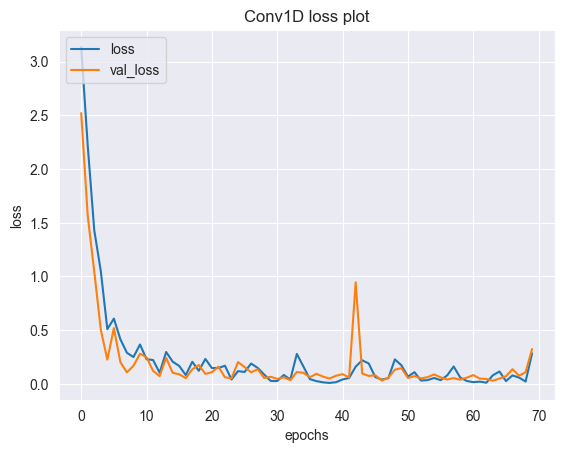

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Conv1D loss plot')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss','val_loss'], loc='upper left')

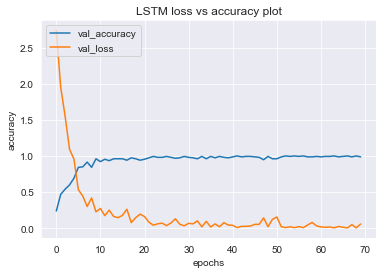

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss vs accuracy plot')
#plt.ylim((0,5))
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['val_accuracy','val_loss'], loc='upper left')

# 8. Make Predictions

In [27]:
result = model.predict(X_test)

6/6 [==============================] - 0s 56ms/step


In [29]:
vision_class.selected_actions[np.argmax(result[2])]

'B'

In [19]:
result[2]

array([6.80671484e-15, 2.16641216e-09, 1.59764443e-12, 1.39515519e-08,
       7.01346536e-08, 1.12836078e-05, 7.42461478e-15, 6.53732346e-10,
       2.06298591e-06, 9.64631825e-16, 3.06622978e-12, 4.48164624e-15,
       2.24035864e-13, 1.91586994e-14, 9.99959946e-01, 1.17993338e-07,
       4.06369554e-06, 4.16253844e-14, 1.06012005e-11, 3.99292659e-13,
       2.20065031e-05, 1.92686524e-13, 1.20504737e-07, 3.13930457e-07,
       3.00692492e-11, 6.97016347e-08, 4.94351449e-10, 8.73127308e-13],
      dtype=float32)

In [75]:
vision_class.selected_actions[np.argmax([.7, .2, .1])]

'A'

In [28]:
vision_class.selected_actions[np.argmax(y_test[2])]

'B'

# 9. Save Weights

In [30]:
model.save('data_gloves_CONV1D_pose.h5')

In [31]:
del model

In [32]:
model = load_model('data_gloves_CONV1D_pose.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [33]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report

In [34]:
y_predict = model.predict(X_test)

6/6 [==============================] - 0s 3ms/step


In [35]:
ytrue = np.argmax(y_test, axis=1).tolist()
y_predict = np.argmax(y_predict, axis=1).tolist()

In [36]:
cf = multilabel_confusion_matrix(ytrue, y_predict)
cf

array([[[161,   0],
        [  0,   7]],

       [[160,   2],
        [  0,   6]],

       [[165,   0],
        [  0,   3]],

       [[163,   0],
        [  0,   5]],

       [[161,   0],
        [  2,   5]],

       [[162,   0],
        [  0,   6]],

       [[165,   0],
        [  0,   3]],

       [[159,   0],
        [  0,   9]],

       [[162,   0],
        [  0,   6]],

       [[162,   0],
        [  0,   6]],

       [[163,   0],
        [  0,   5]],

       [[164,   0],
        [  0,   4]],

       [[160,   0],
        [  0,   8]],

       [[163,   0],
        [  0,   5]],

       [[159,   0],
        [  0,   9]],

       [[162,   0],
        [  0,   6]],

       [[164,   0],
        [  0,   4]],

       [[167,   0],
        [  0,   1]],

       [[162,   0],
        [  0,   6]],

       [[158,   0],
        [  0,  10]],

       [[164,   0],
        [  0,   4]],

       [[155,   0],
        [  0,  13]],

       [[161,   0],
        [  0,   7]],

       [[164,   0],
        [  0, 

In [37]:
accuracy_score(ytrue, y_predict)

0.9821428571428571

In [38]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class - " + class_label)

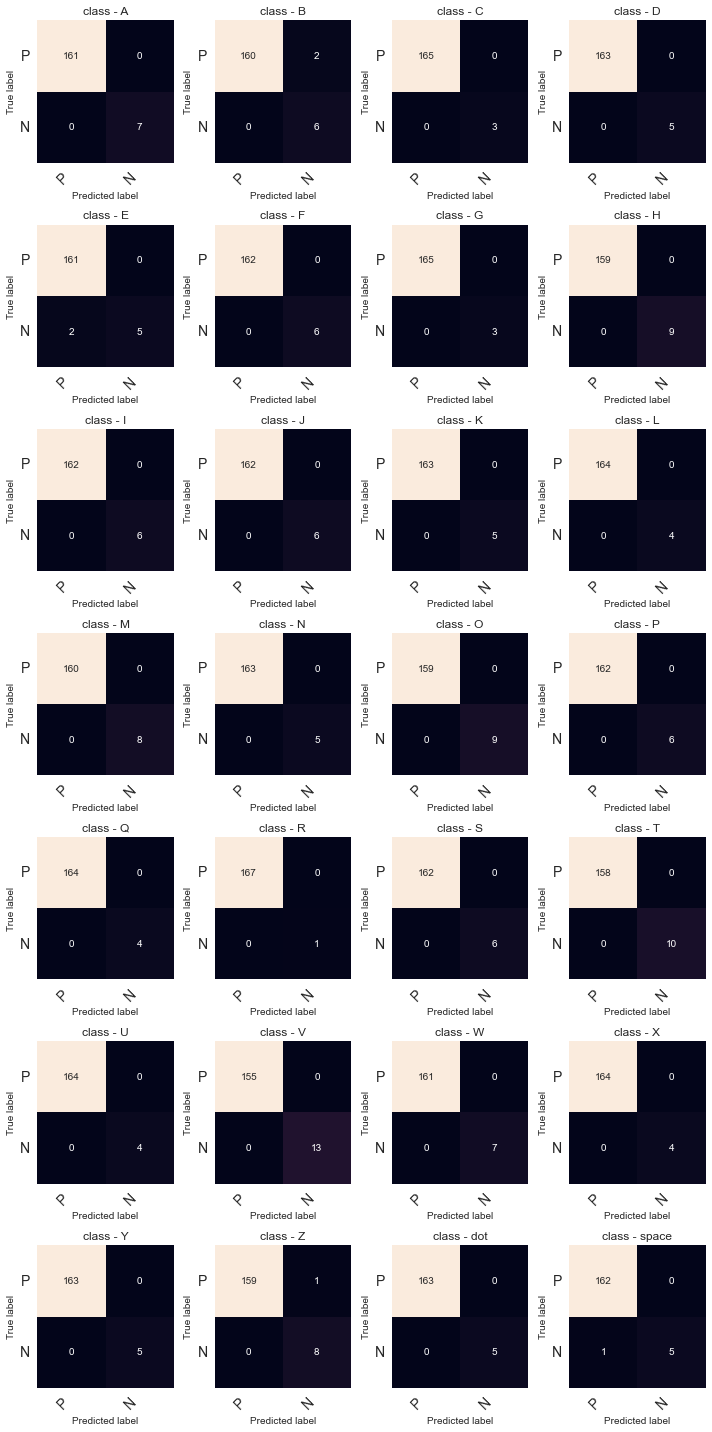

In [39]:

fig, ax = plt.subplots(7, 4, figsize=(10, 20))
for axes, cfs_matrix, label in zip(ax.flatten(), cf, vision_class.selected_actions):
    print_confusion_matrix(cfs_matrix, axes, label, ["P", "N"])
fig.tight_layout()
plt.show()

#cf_df = pd.DataFrame(cf, index=vision_class.selected_actions, columns=vision_class.selected_actions)
#sk.metrics.plot_confusion_matrix(ytrue,y_predict,figsize=(20,20))

In [40]:
print(classification_report(ytrue,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.75      1.00      0.86         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         4
          17       1.00    

# 11. Test in Real Time

In [ ]:
# 1. New detection variables
frame_sequence = []
sentence = []

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with vision_class.mp_holistic.Holistic(min_detection_confidence=0.6, min_tracking_confidence=0.6) as holistic:
        while cap.isOpened():
            _, frame = cap.read()
            image, result = vision_class.mediapipe_detection(frame, holistic)
            if result.right_hand_landmarks is None and result.left_hand_landmarks is None:
                frame_sequence.clear()
                count = 0
                vision_class.draw_styled_landmarks(image, result, is_pose)
                cv2.imshow('Testing feed', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                continue
            else:
                vision_class.draw_styled_landmarks(image, result, is_pose)
                key_points = vision_class.extract_datapoints(result, is_pose)
                frame_sequence.append(key_points)
                cv2.imshow('Testing feed', cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
                count += 1
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            if count == 30:
                vision_class.model_predict(frame_sequence, model, sentence, False)
                if len(sentence) == 0:
                    pass
                else:
                    if sentence[len(sentence) - 1] == '.':
                        sentence.pop()
                        audio.speak(''.join(sentence))
                        sentence.clear()
                    else:
                        pass
                count = 0
cap.release()
cv2.destroyAllWindows()